In [1]:
from neutral_atom_imaging_simulation import Camera, Experiment, ImageGenerator
import matplotlib.pyplot as plt
import state_reconstruction
import sys
import os
if sys.platform == "win32":
    os.add_dll_directory(os.path.abspath('') + "/../")
sys.path.insert(0, os.path.abspath('') + "/../")
import modules.resorting.resorting_cpp as resorting_cpp

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
# Preparation for image simulation

generator = ImageGenerator.ImageGenerator()
generator.read_config_file("simulationSettings.cfg")

# configuring camera
camera = Camera.CMOSCamera(resolution=(1024,1024), binning=1, physical_pixel_size=4.6, magnification=31.25, exposure_time=0.07)
generator.set_camera(camera)
 
dist_pixel = 20
atom_count = 40
dist = (1 - (atom_count - 1) * dist_pixel / camera.resolution[0]) / 2
spacing = (dist_pixel / camera.resolution[0], dist_pixel / camera.resolution[1])
experiment = Experiment.TweezerArray(fill_rate=0.55, survival_probability=1)
experiment.configure_atom_sites_camera_space(spacing,(atom_count,atom_count),(dist,dist),(0,0))  # configures atom locations in physical coordinates
generator.set_experiment(experiment)

In [3]:
# Prepare image deconvolution

import state_reconstruction as srec

import numpy as np

from libics.tools import plot
from libics.tools.trafo.linear import AffineTrafo2d

def prepare_state_reconstruction_dw(psf):
    srec.get_config()
    DEMO_FILENAME = "srec_demo"

    psf_supersample = 1

    site_ref = [0,0]#srec.get_config("trafo_gen.phase_ref_site")
    image_ref = [int(dist * camera.resolution[0]) - dist_pixel,int(dist * camera.resolution[1]) - dist_pixel]#srec.get_config("trafo_gen.phase_ref_image")

    print("site_ref:", site_ref)
    print("image_ref:", image_ref)
    trafo_site_to_image = AffineTrafo2d()
    # Set site unit vectors within image coordinate system
    trafo_site_to_image.set_origin_axes(
        magnification=[dist_pixel,dist_pixel],
        angle=np.deg2rad([0,0])
    )
    trafo_site_to_image.set_offset_by_point_pair(
        site_ref, image_ref
    )
    trafo_site_to_image

    ipsf_gen = srec.IntegratedPsfGenerator(
        psf=psf, psf_supersample=psf_supersample
    )
    ipsf_gen
    plt.imshow(psf)
    plt.colorbar()
    plt.show()

    img_preproc = srec.ImagePreprocessor()
    img_preproc

    proj_gen = srec.ProjectorGenerator(
        trafo_site_to_image=trafo_site_to_image,
        integrated_psf_generator=ipsf_gen,
        proj_shape=(61,61)
    )
    proj_gen

    # Check projector cache directory
    srec.get_config("projector_cache_dir")
    # Pre-calculate projectors (this may take up to a few minutes)
    proj_gen.setup_cache(print_progress=True)

    # If you execute this cell again, this should run instantaneously due to caching
    demo_proj = proj_gen.generate_projector()

    plot.pcolorim(
        demo_proj,
        cmap="RdBu_r", vcen=0, vdif=True, colorbar=True
    )
    plt.show()

    eha = srec.EmissionHistogramAnalysis()
    eha

    sest = srec.StateEstimator(
        id=DEMO_FILENAME,
        image_preprocessor=img_preproc,
        phase_ref_image=image_ref,
        phase_ref_site=site_ref,
        trafo_site_to_image=trafo_site_to_image,
        projector_generator=proj_gen,
        sites_shape=(40,40),
        emission_histogram_analysis=eha,
    )
    sest
    return sest

def state_reconstruction_dw(sest, image):
    # Perform reconstruction
    res = sest.reconstruct(image, thresholds=[52435,58000], analyse_histogram=False)
    return res


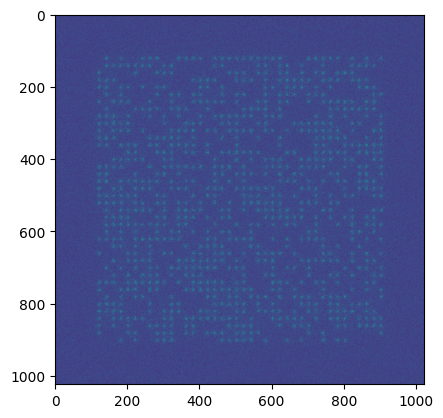

In [4]:
# Create image and acquire point-spread

image, truth = generator.create_image(approximation_steps=1)
plt.imshow(image)
plt.show()
psf = generator.get_psf(41)

site_ref: [0, 0]
image_ref: [102, 102]


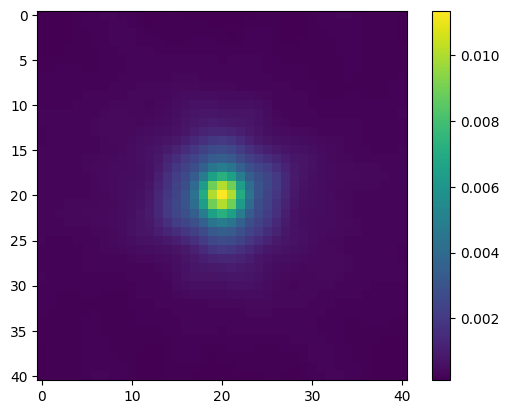

|########################################| 1/1, 0s                             
Loaded from cache file


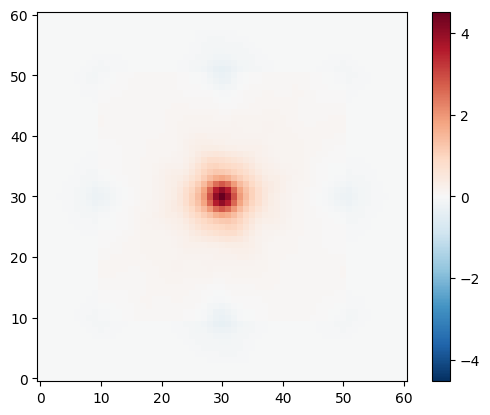

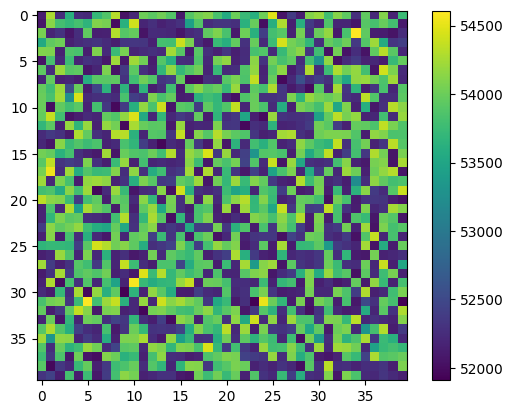

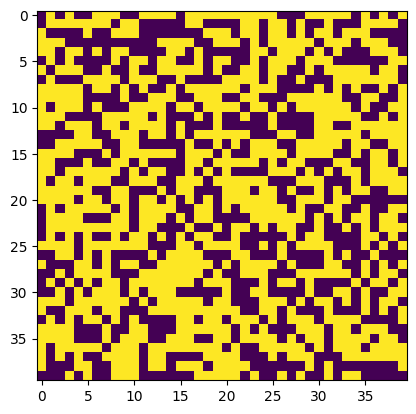

In [8]:
# Prepare and execute image reconstruction

sest = prepare_state_reconstruction_dw(psf)
res = state_reconstruction_dw(sest, image)
plt.imshow(res.emissions.data)
plt.colorbar()
plt.show()
plt.imshow(res.state.data)
plt.show()

In [11]:
# Acquire moves

from modules.resorting import resorting_cpp

state_array = res.state.data.copy()
filled_shape = np.array([20,20],np.int32)

# At the moment only function offered by resorting package
# Parameters: (stateArray: numpy.ndarray[bool[m, n], flags.writeable], filledShape: numpy.ndarray[numpy.int32[2, 1]])
# Returns: list[Move] (struct with x,y,xDir,yDir)
moves = resorting_cpp.sortSequentiallyByRow(state_array.astype(bool), filled_shape)

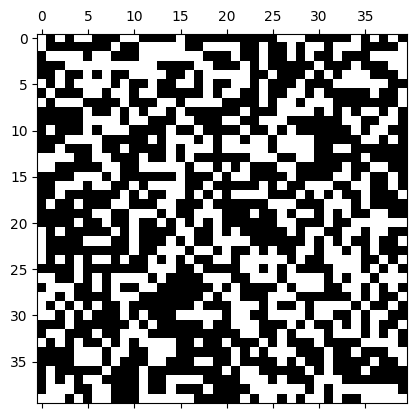

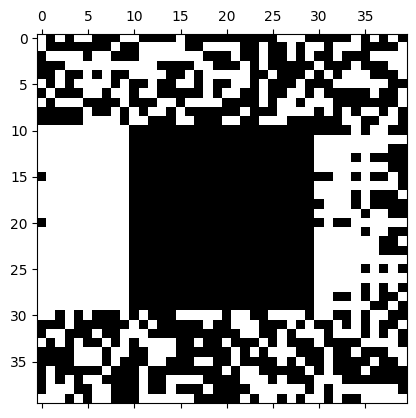

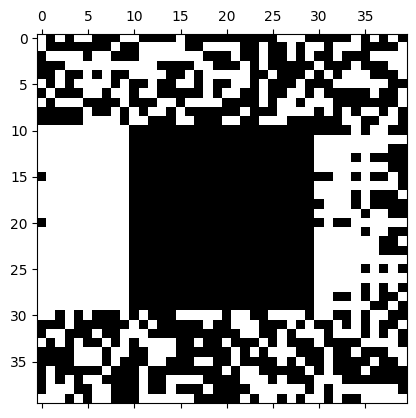

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mplcolors

# Visualization
moveIndex = 0
moveCount = 0

levels = [0, 1, 2, 3, 4]
colors = ['white', 'black', 'green', 'red']
cmap, norm = mplcolors.from_levels_and_colors(levels, colors)

state_array_copy = res.state.data.copy()

# Check validity of move list
fig, ax = plt.subplots()
mat = ax.matshow(state_array_copy, cmap=cmap, norm=norm, interpolation='none')
plt.show()
for move in moves:
    if move.xDir != 0:
        for xtmp in range(move.x + move.xDir, move.x, -np.sign(move.xDir)):
            if(state_array_copy[move.y,xtmp]):
                print("Atom in movement path at " + str(xtmp) + "/" + str(move.y))
    else:
        for ytmp in range(move.y + move.yDir, move.y, -np.sign(move.yDir)):
            if(state_array_copy[ytmp,move.x]):
                print("Atom in movement path at " + str(move.x) + "/" + str(ytmp))
    if not state_array_copy[move.y,move.x]:
        print("Starting location not filled")
    state_array_copy[move.y,move.x] = 0
    state_array_copy[move.y + move.yDir,move.x + move.xDir] = 1
for x in range((atom_count - filled_shape[1]) // 2, (atom_count - filled_shape[1]) // 2 + filled_shape[1]):
    for y in range((atom_count - filled_shape[0]) // 2, (atom_count - filled_shape[0]) // 2 + filled_shape[0]):
        if not state_array_copy[y,x]:
            print("Target location not filled")
fig, ax = plt.subplots()
mat = ax.matshow(state_array_copy, cmap=cmap, norm=norm, interpolation='none')
plt.show()

# Create video sequence visualising moves

state_array_copy = res.state.data.copy()

def applyMove():
    global moveIndex, state_array_copy
    for x in range(0,atom_count):
        for y in range(0,atom_count):
            if state_array_copy[y,x] > 1:
                state_array_copy[y,x] = 0
    if moveIndex >= len(moves):
        return
    move = moves[moveIndex]
    moveIndex += 1
    state_array_copy[move.y,move.x] = 0
    state_array_copy[move.y + move.yDir,move.x + move.xDir] = 1
    if move.xDir != 0:
        for xtmp in range(move.x, move.x + move.xDir, np.sign(move.xDir)):
            state_array_copy[move.y,xtmp] = 2
    else:
        for ytmp in range(move.y, move.y + move.yDir, np.sign(move.yDir)):
            state_array_copy[ytmp,move.x] = 2
    state_array_copy[move.y,move.x] = 3

def update(i):
    applyMove()
    mat.set_data(state_array_copy)
    return mat

fig, ax = plt.subplots()
mat = ax.matshow(state_array_copy, cmap=cmap, norm=norm, interpolation='none')
ani = animation.FuncAnimation(fig, update, len(moves) + 20, interval=100)
ani.save('animationS1.mp4')
plt.show()